In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


## Importing the dataset to dataframe

we can use usecols command to just use only some columns

In [35]:
df = pd.read_csv(r'/kaggle/input/disaster-tweets/tweets.csv', usecols = ['text', 'target'])

In [36]:
df

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0


In [37]:
df.isnull().sum()

text      0
target    0
dtype: int64

### We should shuffel the dataset for better accuracy. So model cant find any patterns

In [38]:
df = df.sample(frac = 1).reset_index(drop = True)
df

,text,target
0,Drone Fans 1 Pc Storage Spark Mini Drone Body ...,0
1,Horizontal cyclone!? https://t.co/7RVsiEO8wE,0
2,WTF !!! Don't have guts to ban burkha which is...,0
3,Recover quicker? Phew! It’s not like bees are ...,0
4,"Hi there, I'm very sorry to hear this, we are ...",1
...,...,...
11365,I thought it was the 10 of swords then I googl...,0
11366,There’s something hilarious about old GOP dono...,0
11367,Any election in which the Greens are obl… http...,0
11368,An Afghan child stands in the cold holding bre...,1


In [39]:
df['target'].value_counts()

target
0    9256
1    2114
Name: count, dtype: int64

In [40]:
df = df.rename(columns={'target':'label'})

# So data is imbalance and also not preprocessed and cleaned. but in transformers we dont need to preprocess the data

<Axes: >

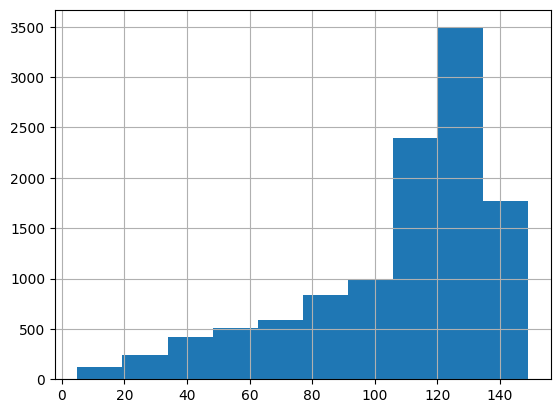

In [41]:
df['text'].str.len().hist()

## Convert data for transformers

In [42]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 11370
})

## Now splitting the dataset

In [43]:
dataset = dataset.train_test_split(test_size = 0.2)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9096
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2274
    })
})

In [44]:
dataset['train'][0]

{'text': 'Apple Field - A mix of Red &amp; White Pollen - Hazard: 2 Scorpions (Or 1 Worm if you plan on using that mob…',
 'label': 0}

In [45]:
id2label = {0:'general', 1:'disastet'}
label2id = {'general':0, 'disastet':1}

## We dont need to lable encode because labels already converted to numerical

## Data Tokenization

In [46]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [47]:
tokenizer

BertTokenizerFast(name_or_path='huawei-noah/TinyBERT_General_4L_312D', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [48]:
tokenizer(dataset['train'][0]['text'])


def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=100)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size = None)

Map:   0%|          | 0/9096 [00:00<?, ? examples/s]

Map:   0%|          | 0/2274 [00:00<?, ? examples/s]

In [49]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9096
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2274
    })
})

In [50]:
tokenizer(dataset['train'][0]['text'])

{'input_ids': [101, 6207, 2492, 1011, 1037, 4666, 1997, 2417, 1004, 23713, 1025, 2317, 22482, 1011, 15559, 1024, 1016, 22015, 2015, 1006, 2030, 1015, 15485, 2065, 2017, 2933, 2006, 2478, 2008, 11240, 1529, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Model evaluaation function

In [52]:
# pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

## computing the matrix

In [53]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Building the model

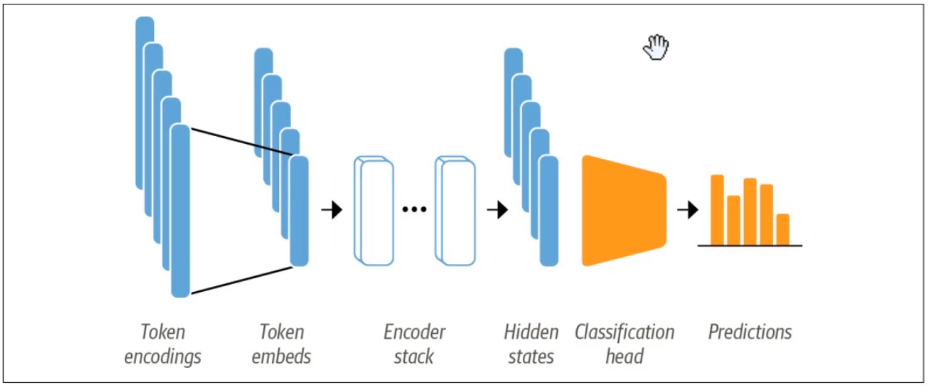

In [54]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Arguments and Trainer for model

In [71]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy='epoch')

trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer)

## Training the model

In [72]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.767118,0.852243
2,No log,0.636859,0.874230
3,No log,0.629812,0.883905
4,0.024500,0.764490,0.859719
5,0.024500,0.679591,0.875989


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=715, training_loss=0.02310823160451609, metrics={'train_runtime': 53.3298, 'train_samples_per_second': 852.807, 'train_steps_per_second': 13.407, 'total_flos': 96801667320960.0, 'train_loss': 0.02310823160451609, 'epoch': 5.0})

In [73]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6795908808708191,
 'eval_accuracy': 0.8759894459102903,
 'eval_runtime': 1.2331,
 'eval_samples_per_second': 1844.068,
 'eval_steps_per_second': 29.194,
 'epoch': 5.0}

### Here we get the accuracy 87% evaluation task

## Saving the model and Load for inference

In [74]:
trainer.save_model('tinyBERT-disaster-tweet')

## Zip the file and download the zip

In [75]:
import shutil

shutil.make_archive('zipped_directory', 'zip', '/kaggle/working/tinyBERT-disaster-tweet')

'/kaggle/working/zipped_directory.zip'

In [77]:
from IPython.display import FileLink

FileLink('zipped_directory.zip')

/kaggle/working/zipped_directory.zip

## Testing via predictions

In [78]:
from transformers import pipeline
import torch

In [80]:
data=['As Taiwan braced itself for the impending arrival of Typhoon Krathon, the island nation came to a standstill. With torrential rain lashing the southern region, the authorities took no chances as they shut down schools, offices, and financial markets in anticipation of the storm’s impact.',
     "Today's forecast promises the sky to be rain. Please plan your day according to the temperature and predicted weather conditions. Enjoy the sunshine and don't forget your sunscreen and sunglasses as you soak up the weather.The AQI in Mumbai today stands at 168.0, indicatingpoorair quality in the city. Children and people with respiratory diseases, such as asthma, should limit prolonged outdoor activity. Being aware of the AQI helps one make informed decisions regarding one's overall well-being while planning the day’s activities."]

In [81]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model= 'tinyBERT-disaster-tweet', device = device)

In [84]:
classifier(data)

[{'label': 'disastet', 'score': 0.9939042925834656},
 {'label': 'general', 'score': 0.9991297125816345}]